In [1]:
import numpy as np
import matplotlib.pyplot as plt
import abtem
import ase

## Build atomic potential

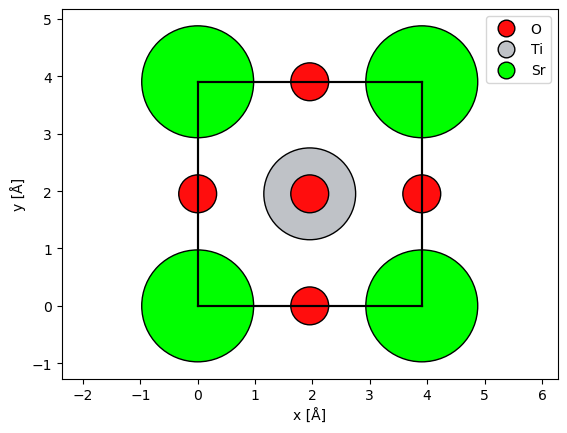

In [2]:
srtio3 = ase.io.read("/Users/test/trondhiem/srtio3_100.cif")
abtem.show_atoms(
    srtio3,
    show_periodic=True,
    scale=0.5,
    legend=True,
);

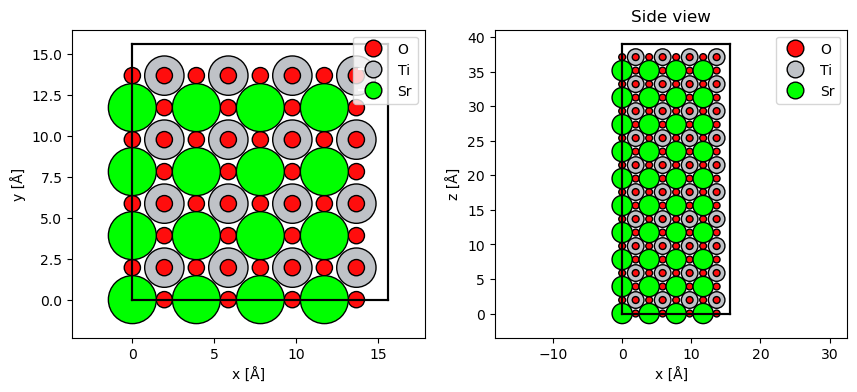

In [3]:
srtio3 = ase.io.read("/Users/test/trondhiem/srtio3_100.cif")
repeated_srtio3 = srtio3 * (4, 4, 10)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

abtem.show_atoms(repeated_srtio3, ax=ax1, legend=True)
abtem.show_atoms(repeated_srtio3, legend=True, plane="xz", title="Side view", ax=ax2);


[########################################] | 100% Completed | 4.80 ss


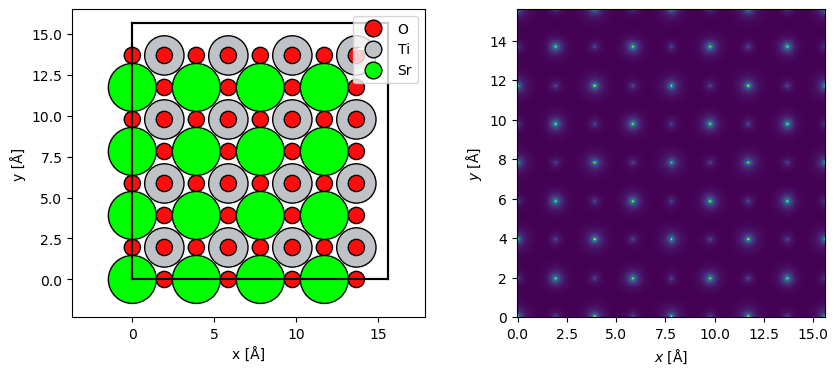

In [4]:
potential = abtem.Potential(
    repeated_srtio3,
    sampling=0.05,
    parametrization="lobato",
    slice_thickness=1,
    projection="finite",
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
abtem.show_atoms(repeated_srtio3, ax=ax1, legend=True)
visualization = (potential.build() * 0.1).show(ax=ax2);

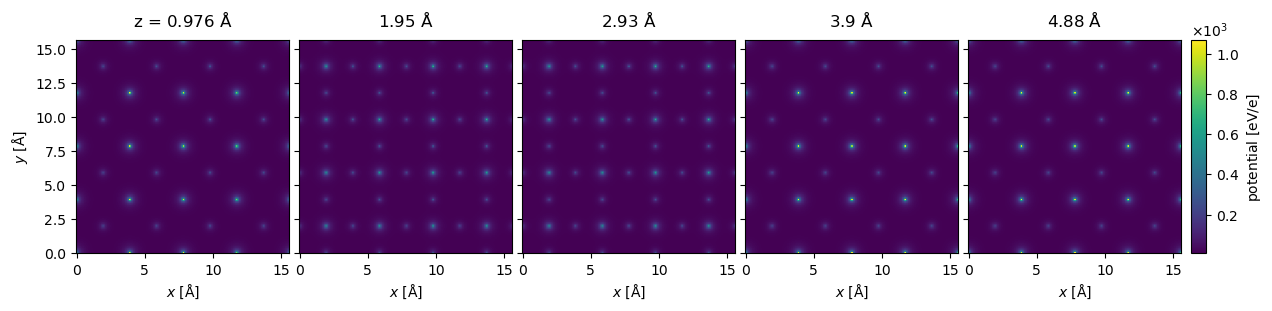

In [5]:
visualization = potential[:5].show(
    project=False,
    explode=True,
    figsize=(14, 5),
    common_color_scale=True,
    cbar=True,
)

In [6]:
potential_array = potential.build().compute()

[########################################] | 100% Completed | 4.62 ss


## Initialize probe

[########################################] | 100% Completed | 106.27 ms


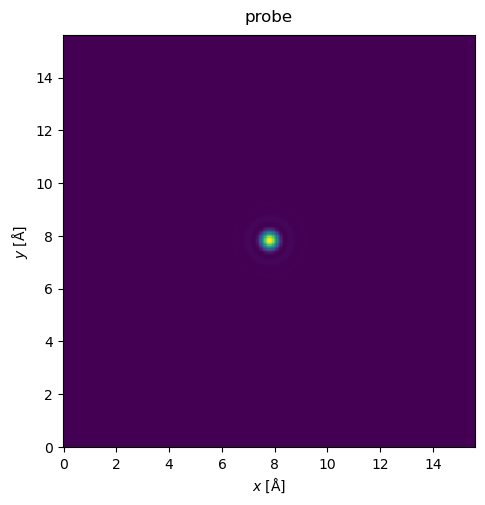

In [7]:
energy = 200e3 # voltages
semiangle_cutoff = 25 # mrad
defocus = 0 # angstrom
aberrations = {"C10": -defocus, 
               "C12": 0, "phi12": -0.5, 
               "C21": 0, "phi21": 0.1,
               "C23": 0, "phi23": 0.4,
               "C30": 0e5, 
               "C32": 0e4, "phi32": 0.9,
               "C34": 0e4, "phi34": 0.4,
              }

probe = abtem.Probe(
    semiangle_cutoff=semiangle_cutoff,
    energy=energy,
    **aberrations,
    device="cpu",
)

probe.match_grid(potential)

probe.show(cmap='viridis', title="probe")

## Grid scan simulation

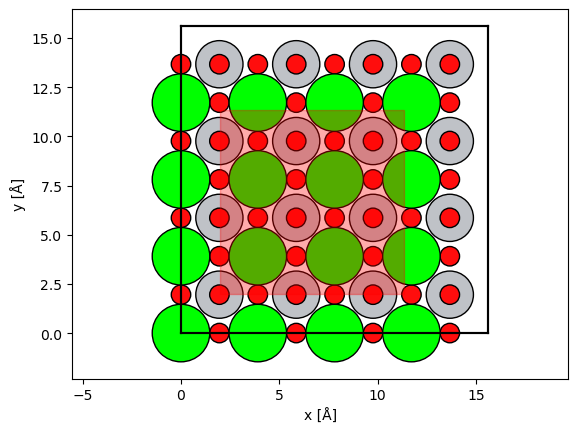

In [8]:
maximum_scattering_angle_mrad = 50 # mrad
scan_step_size = 0.24 # angstrom
scan_pixels = 39
scan_start = [2, 2]
scan_end = [scan_start[0] + scan_step_size*scan_pixels, scan_start[1] + scan_step_size*scan_pixels]

pixelated_detector = abtem.PixelatedDetector(max_angle=maximum_scattering_angle_mrad)

gridscan = abtem.GridScan(
    start=scan_start, 
    end=scan_end,
    # fractional=True,
    potential=potential,
    sampling=scan_step_size,
)

fig, ax = abtem.show_atoms(repeated_srtio3)
gridscan.add_to_plot(ax)

[########################################] | 100% Completed | 75.41 s


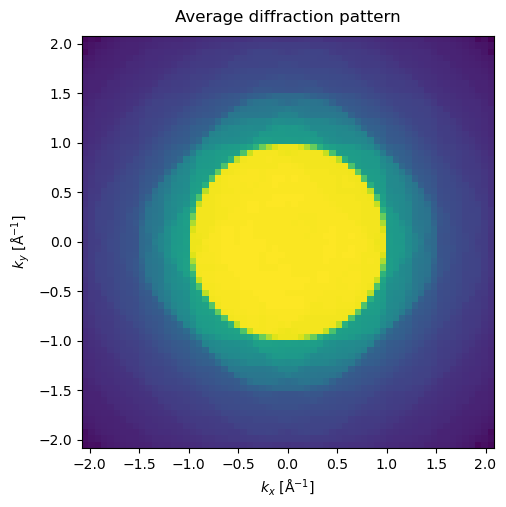

In [9]:
# Simulation
diffraction_patterns = probe.scan(potential, 
                                  scan=gridscan, 
                                  detectors=pixelated_detector,
                                  )
diffraction_patterns.compute()
diffraction_patterns.mean((0,1)).show(power=0.25, title='Average diffraction pattern', cmap='viridis')

In [10]:
# Saving dataset
data_dict = {
    'data_4D': np.float32(diffraction_patterns.array),
    'scan_step_size': scan_step_size,
    'aperture_size': semiangle_cutoff/1e3,
    'voltage': energy/1e3,
    'dose': 'infinity'
}
filename = f'STO10x{int(energy/1000)}kV_{int(semiangle_cutoff)}mrad_noise_free.npy'
np.save(filename, data_dict)

## Apply Poisson noise

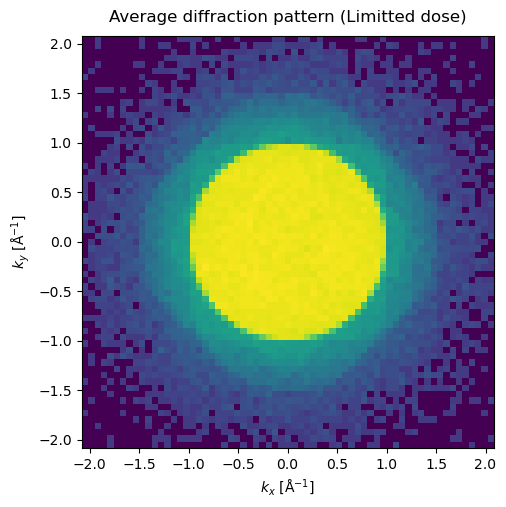

In [11]:
# Apply poisson noise
dose = 1e4 # electrons per square angstrom
measurement_noise = diffraction_patterns.poisson_noise(dose)
measurement_noise.mean((0,1)).show(power=0.25, 
                                   title='Average diffraction pattern (Limitted dose)', 
                                   cmap='viridis')
data_4D = measurement_noise.array

In [12]:
print(f'dataset size:\t {data_4D.shape}')
print(f'scan step size:\t {scan_step_size} A')
print(f'aperture size:\t {int(semiangle_cutoff)} mrad')
print(f'voltage:\t {int(energy/1000)} keV')
print(f'dose:\t\t {int(dose)} e/A^2')

dataset size:	 (39, 39, 65, 65)
scan step size:	 0.24 A
aperture size:	 25 mrad
voltage:	 200 keV
dose:		 10000 e/A^2


In [13]:
# Saving dataset
data_dict = {
    'data_4D': np.float32(measurement_noise.array),
    'scan_step_size': scan_step_size,
    'aperture_size': semiangle_cutoff/1e3,
    'voltage': energy/1e3,
    'dose': dose
}
filename = f'STO_{int(energy/1000)}kV_{int(semiangle_cutoff)}mrad_dose_{int(dose)}.npy'
filename = f'STO10x_current.npy'
np.save(filename, data_dict)

# Single side-band (SSB) ptychography reconstruction

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import sys
#sys.path.append('/Users/test/repos/pyptychostem/') # path to pyptychostem
sys.path.append('./Songge_1/') # path to pyptychostem
from STEM4D import *
%matplotlib widget

## Load dataset and set parameters

In [15]:
#filename = '../WS2_200kV_25mrad_noise_free.npy'
#filename = 'STO_200kV_25mrad_dose_10000.npy'
filename = f'STO10x_current.npy'
data = np.load(filename, allow_pickle=True).item()
parfile = {'aperture': data['aperture_size'], 
           'voltage': data['voltage'], 
           'stepsize': data['scan_step_size'], 
           'threshold': 0.2}
data_4D = Data4D(parfile, data=data['data_4D'])
#data_4D.bin_Q(bin_factor=2)
data_4D.estimate_aperture_size()
data_4D.plot_4D()

{'aperture': 0.025, 'voltage': 200.0, 'stepsize': 0.24, 'threshold': 0.2}


<Signal2D, title: 4D data, dimensions: (39, 39|65, 65)>

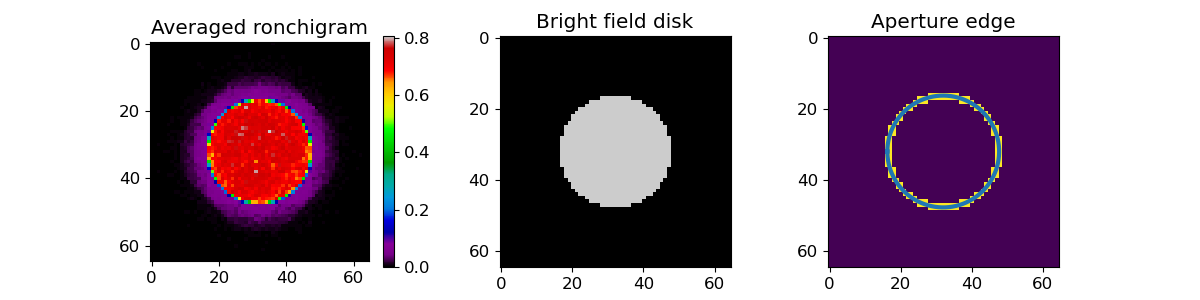

In [16]:
data_4D.plot_aperture()


## Fourier transform 4D dataset in scanning space $G(\mathbf{K_f, Q})=\mathcal{F}_{\mathbf{r}}\{I(\mathbf{K_f, r})\}$

In [17]:
data_4D.truncate_ronchigram(expansion_ratio=None) # crops ronchigram to the BF disk
data_4D.apply_FT()


In [18]:
data_4D.plot_4D_reciprocal(signal='amplitude')

<Signal2D, title: FT of 4D data, dimensions: (39, 39|65, 65)>

In [19]:
data_4D.plot_4D_reciprocal_both()

The module://ipympl.backend_nbagg matplotlib backend is not compatible with the traitsui GUI elements. For more information, read http://hyperspy.readthedocs.io/en/stable/user_guide/getting_started.html#possible-warnings-when-importing-hyperspy.


<Signal2D, title: FT of 4D data, dimensions: (39, 39, 2|65, 65)>

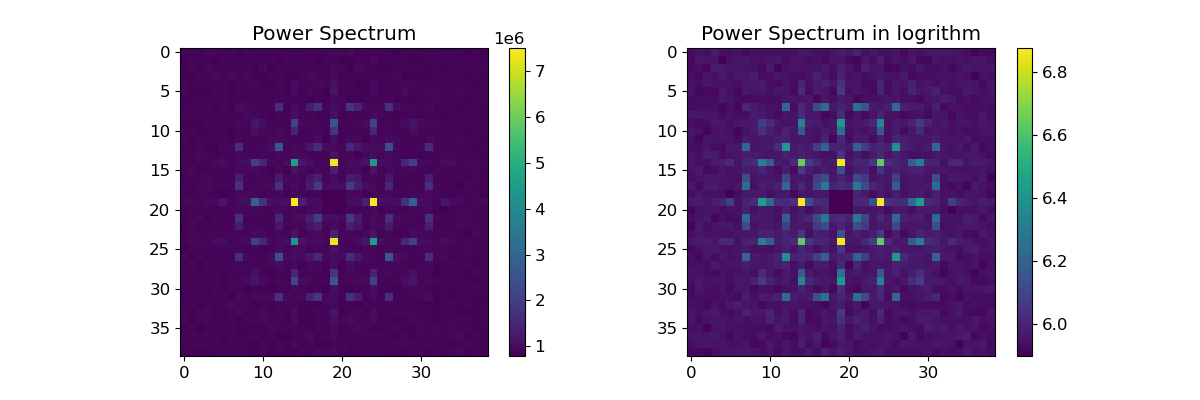

In [20]:
data_4D.remove_zero_frequency()
data_4D.plot_FT()

## Reconstruct without aberration correction

In [21]:
plt.close('all')
%matplotlib inline

In [22]:
ssb = SSB(data_4D)
ssb.run()

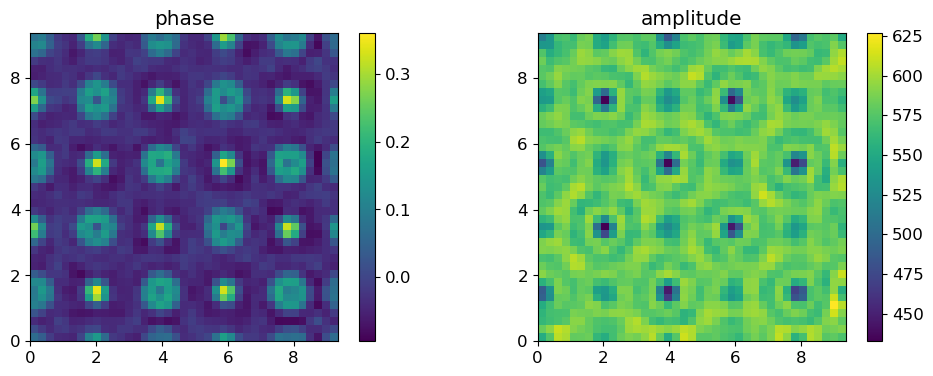

In [23]:
ssb.plot_result()

# phase offset

In [24]:
import numpy as np
from tifffile import tifffile
import matplotlib.pyplot as plt
#from ipywidgets import *
from ipywidgets import interact
%matplotlib widget
# use notebook if jupyter notebook is used

In [25]:
def FFT_2D (array):
    result=np.fft.fft2(array)
    result=np.fft.fftshift(result)
    return result
def IFFT_2D (array):
    result=np.fft.ifftshift(array)
    result=np.fft.ifft2(result)
    return result

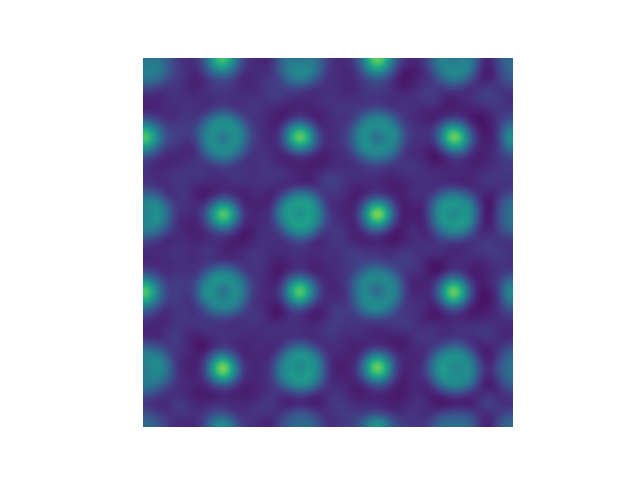

In [26]:
phase_rs= ssb.phase
amp_rs= ssb.amplitude

plt.imshow(phase_rs, interpolation='bicubic')
plt.axis('off')
plt.show()

In [27]:
obj_ft = FFT_2D(amp_rs*np.exp(-1j*phase_rs))
phase0 = np.angle(obj_ft)
amp0 = np.abs(obj_ft)
center = [int(phase0.shape[0]/2),int(phase0.shape[1]/2)]

# plt.imshow(phase0, interpolation='bicubic')
# plt.axis('on')
# plt.show()

obj_ft = FFT_2D(amp_rs*np.exp(-1j*phase_rs))
phase0 = np.angle(obj_ft)
amp0 = np.abs(obj_ft)
center = [int(phase0.shape[0]/2),int(phase0.shape[1]/2)]

interactive(children=(FloatSlider(value=0.0, description='offset', max=3.141592653589793, min=-3.1415926535897…

<function print(*args, sep=' ', end='\n', file=None, flush=False)>

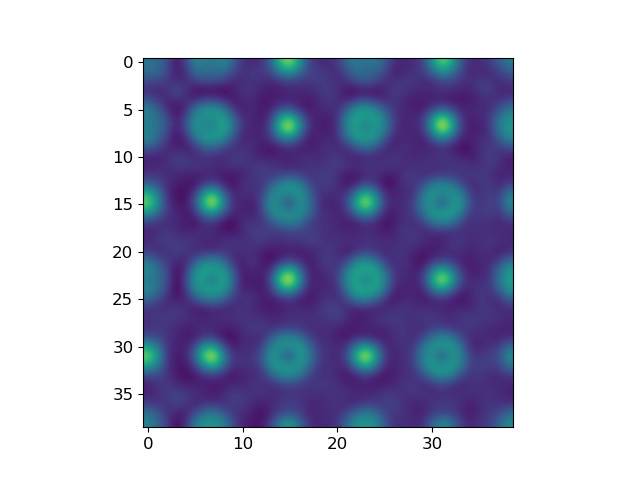

In [31]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
im = plt.imshow(phase_rs, interpolation='bicubic')
phase = phase0.copy()
new_phase = phase.copy()

def update(offset = 0.0):
    global new_phase
    phase = phase0.copy()
    phase[center[0],center[1]]+=offset
    #phase +=offset
    new_obj = amp0*np.exp(-1j*phase)
    new_phase = np.angle(IFFT_2D(new_obj))
    #new_phase/=np.std(new_phase)
    #new_phase-=np.mean(new_phase)

    im.set_data(new_phase)
    plt.clim(vmin=np.min(new_phase),vmax=np.max(new_phase))
    fig.canvas.draw_idle()

interact(update, offset=(-np.pi,np.pi,0.1))
print